# Merged notebook containing code and learnings from cxr project
This notebook is meant as a starting point for the master thesis neural net. Ideas, learnings and code from previous notebooks is gathered and described, to summarize the current status of the project.

## Overview
*1. Preamble*<br>
Imort of packages<br>
Configuration variables like file paths, boolean switches, numeric settings, etc.

*2. Getting the data*<br>
Funciton definitions<br>
Read meta data + image files and convert it to a dataframe<br>
Unify labling of datasets<br>
Train / Test / Val split<br>
Shuffling data

*3. Data preprocessing*<br>
Image augmentation<br>
Data generator class<br>

*4. Model training*<br>
**TODO: Think about a concept for comparing the nets**<br>
Define neural net architecture<br>
Model settings like learning rate reduction, early stopping, model save setting<br>
Training the model

*5. Model evaluation*<br>
Check performance parameters like:
- accuracy
- loss
- recall
- f1

Evaluate generalizability on validation data<br>
Show confusion matrix

# 1. Preamble

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Config
IMG_SIZE = 224
BATCH_SIZE=32    # viele paper verwenden 16, abhängig von der grafikkarte
CHANNELS=1
TRANSFER_LEARNING=True
DEBUG_AND_TEST_MODE=False
USE_CUSTOM_DATAGEN=False

MODELSAVE = "home/9424/NAVARA/masterarbeit/chest_x_ray/models/"
MODELSAVE = MODELSAVE + "vgg16_flatten_chexpert_mimic_cxr14_nodropout.h5"

pd.set_option('display.max_colwidth', None)

DATASET_SOURCE = 1
USE_AWS = False
if USE_AWS:
    DATSET_SOURCE = 2
    
base_path = ''

if DATASET_SOURCE == 0:      # local
    base_path = '/mnt/f/DatasetsChestXRay/'
elif DATASET_SOURCE == 1:    # oth amberg
    base_path = '/home/9424/NAVARA/masterarbeit/datasets/'
elif DATASET_SOURCE == 2:    # aws
    base_path = ''

datasets_224 = {
    #'padchest': 'BIMCV-PadChest_224/',
    'cxr14': 'ChestX-ray14_NationalInstituesofHealthClinicalCenter_224/',
    'chexpert': 'CheXpert_224/',
    #'kermany': 'KermanyChildStudy_224/',
    'mimic': 'MIMIC-CXR_224/',
    #'openi': 'Open-i_IndianaUniversityNetworkforPatientCare_224/'
}

datasets = {
    #'padchest': 'BIMCV-PadChest/',
    'cxr14': 'ChestX-ray14_NationalInstituesofHealthClinicalCenter/',
    'chexpert': 'CheXpert/',
    #'kermany': 'KermanyChildStudy/',
    'mimic': 'MIMIC-CXR/',
    #'openi': 'Open-i_IndianaUniversityNetworkforPatientCare/'
}

## Dataset parent class
A class that is suitable for creating a combined dataset consisting of different original datasets

In [4]:
class dataset:
    def __init__(self, dataset_dict=None):
        self.df = None
        self.train = None
        self.test = None
        self.val = None
        
        first = True
        if dataset_dict is not None:
            for dataset_name, dataset in dataset_dict.items():
                if first:
                    first = False
                    self.df = dataset.df
                else:
                    self.df = pd.concat([self.df, dataset.df], ignore_index=True)

    def train_test_split(self, test_size=0.2, stratif_column='label_pneumonia'):
        self.train, self.test = train_test_split(self.df, test_size=test_size, stratify=None if stratify_column is None else self.df[stratify_column])
    
    def stratified_train_test_val_split(self, val_size=0.1, test_size=0.2, stratify_column='label_pneumonia'):
        print("Splitting in:", (1-val_size-test_size), "train,", test_size, "test,", val_size, "val")
        tmp_remaining_df, self.val = train_test_split(self.df,
                                                 test_size=val_size,
                                                 stratify=None if stratify_column is None else self.df[stratify_column])
        
        second_split_size = test_size / (1 - val_size)
        self.train, self.test = train_test_split(tmp_remaining_df,
                                                test_size=second_split_size,
                                                stratify=None if stratify_column is None else tmp_remaining_df[stratify_column])

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        
    def shuffle_all(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        if self.train is not None:
            self.train = self.train.sample(frac=1).reset_index(drop=True)
        else:
            print("Can't shuffle training data (emtpy)")
        if self.test is not None:
            self.test = self.test.sample(frac=1).reset_index(drop=True)
        else:
            print("Can't shuffle test data (empty)")
        if self.val is not None:
            self.val = self.val.sample(frac=1).reset_index(drop=True)
        else:
            print("Can't shuffle val data (empty)")

## Dataset child class
A class that is used to retrieve data from the original datasets

In [5]:
class original_dataset(dataset):
    def __init__(self, name, folder):
        super().__init__()
        self.name = name
        self.folder = folder
        self.path = base_path + self.folder
        self.df = self.create_dataset()

    def create_dataset(self):
        # initialize dataframe
        data = {}
        i = 0
        # iterate over folders and files
        for label_folder in ['normal/', 'pneumonia/']: # ['normal/', 'pneumonia/']
            for filename in os.listdir(self.path + label_folder):
                img_path = self.path + label_folder + str(filename)
                label_pneumonia = 0
                if label_folder == 'pneumonia/':
                    label_pneumonia = 1
                data[i] = {'img': img_path, 'dataset': self.name, 'label_pneumonia': label_pneumonia, 'label_viral': None, 'label_covid': None}
                i = i + 1

        print("Successfully created " + self.name + " dataset")
        return pd.DataFrame.from_dict(data, "index")


In [6]:
#i = 0
#data = {}
#csv_df = pd.read_csv('/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR/final_normal_meta_data_filtered.csv')
#csv_df = csv_df[csv_df['NoFinding'] == 1.0]

#for filename in os.listdir('/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR/normal/'):
#    img_path = '/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR/normal/' + str(filename)
#    img_identifier = str(filename).split('.')[0]
#    if csv_df['dicom_id'].str.contains(img_identifier).sum() > 0:
#        data[i] = {'img': img_path, 'dataset': 'mimic', 'label_pneumonia': 0, 'label_viral': None, 'label_covid': None}
#    i += 1
#df = pd.DataFrame.from_dict(data, "index")

In [7]:
#len(df)

# 2. Load Data

In [8]:
# dictionary of all datasets
dataset_dict = {}

# load all datasets and execute a train test split
#for dataset_name, folder_name in datasets.items():
for dataset_name, folder_name in datasets_224.items():
    tmp_dataset = original_dataset(dataset_name, folder_name)
    #tmp_dataset.train_test_split()
    #tmp_dataset.shuffle()
    dataset_dict[dataset_name] = tmp_dataset

Successfully created cxr14 dataset
Successfully created chexpert dataset
Successfully created mimic dataset


In [9]:
# Datensätze kombinieren
combined_dataset = dataset(dataset_dict)
combined_dataset.shuffle()

# teilmenge für schnelle tests verwenden
#combined_dataset.df, ignore = train_test_split(combined_dataset.df, test_size=0.5,
                                                 #stratify=combined_dataset.df['label_pneumonia'])
#combined_dataset.df = combined_dataset.df.head(1000)
#combined_dataset.df = combined_dataset.df.head(len(df))
#combined_dataset.df = combined_dataset.df.append(df)
#combined_dataset.shuffle()

# train-test-split
combined_dataset.stratified_train_test_val_split(stratify_column='label_pneumonia')

Splitting in: 0.7 train, 0.2 test, 0.1 val


In [10]:
combined_dataset.df.head()

,img,dataset,label_pneumonia,label_viral,label_covid
0,/home/9424/NAVARA/masterarbeit/datasets/CheXpert_224/normal/patient47618study1view2_frontal.jpg,chexpert,0,None,None
1,/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR_224/normal/6ac11ae5-6a831ca6-22c9adfd-7b078c3e-bb7db64f.jpg,mimic,0,None,None
2,/home/9424/NAVARA/masterarbeit/datasets/CheXpert_224/normal/patient36845study1view1_frontal.jpg,chexpert,0,None,None
3,/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR_224/pneumonia/dee6301a-5e710406-8800e646-4620a456-edb252b1.jpg,mimic,1,None,None
4,/home/9424/NAVARA/masterarbeit/datasets/CheXpert_224/pneumonia/patient11838study2view1_frontal.jpg,chexpert,1,None,None


In [11]:
combined_dataset.df[combined_dataset.df['label_pneumonia'] != 1].head()

,img,dataset,label_pneumonia,label_viral,label_covid
0,/home/9424/NAVARA/masterarbeit/datasets/CheXpert_224/normal/patient47618study1view2_frontal.jpg,chexpert,0,None,None
1,/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR_224/normal/6ac11ae5-6a831ca6-22c9adfd-7b078c3e-bb7db64f.jpg,mimic,0,None,None
2,/home/9424/NAVARA/masterarbeit/datasets/CheXpert_224/normal/patient36845study1view1_frontal.jpg,chexpert,0,None,None
5,/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR_224/normal/ac38d60a-653f4710-73066293-ceac153a-1693dfa3.jpg,mimic,0,None,None
6,/home/9424/NAVARA/masterarbeit/datasets/MIMIC-CXR_224/normal/7bb66485-38057227-908eb7d6-c834e3d6-7af06b90.jpg,mimic,0,None,None


In [12]:
#combined_dataset.df = combined_dataset.df.head(2000)

In [13]:
print('Zusammenfassung des kombinierten Datensatzes:')
n_normal = sum(combined_dataset.df.label_pneumonia < 0.5)
n_pneumonia = sum(combined_dataset.df.label_pneumonia > 0.5)
print('Anzahl Samples:', len(combined_dataset.df), '   ->', n_normal,'normal,', n_pneumonia, 'pneumonia')
print('         Train:', len(combined_dataset.train),'   ->', sum(combined_dataset.train.label_pneumonia < 0.5), 'normal,', sum(combined_dataset.train.label_pneumonia > 0.5), 'pneumonia')
print('          Test:', len(combined_dataset.test),'   ->', sum(combined_dataset.test.label_pneumonia < 0.5), 'normal,', sum(combined_dataset.test.label_pneumonia > 0.5), 'pneumonia')
print('           Val:', len(combined_dataset.val),'   ->', sum(combined_dataset.val.label_pneumonia < 0.5), 'normal,', sum(combined_dataset.val.label_pneumonia > 0.5), 'pneumonia')

Zusammenfassung des kombinierten Datensatzes:
Anzahl Samples: 45801    -> 22893 normal, 22908 pneumonia
         Train: 32060    -> 16025 normal, 16035 pneumonia
          Test: 9160    -> 4578 normal, 4582 pneumonia
           Val: 4581    -> 2290 normal, 2291 pneumonia


# 3. Data Preprocessing

## Image Augmentation

In [14]:
import imgaug.augmenters as iaa
aug = iaa.AllChannelsCLAHE(clip_limit=(0.05))

In [15]:
def applySigmoidContrast(img):
    img = aug.augment_image(img)
    return img

In [16]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes25 = lambda aug: iaa.Sometimes(0.25, aug)

seq_img = iaa.Sequential([
    # sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

## Data Generator class

In [17]:
if DEBUG_AND_TEST_MODE:
    # just testing some stuff
    path = dataset_dict['mimic'].df.iloc[0].img
    img = cv2.resize(cv2.imread(str(path), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    #img = img.reshape(img.shape[0], img.shape[1])
    print(np.shape(img))
    rgb = np.repeat(img[..., np.newaxis], 3, -1)
    print(np.shape(rgb))
    seq_img_i = seq_img.to_deterministic()   
    img = seq_img_i.augment_image(img)
    plt.imshow(img, cmap='gray')

In [18]:
if DEBUG_AND_TEST_MODE:
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    
    ax1.imshow(rgb[:,:,0], cmap='gray')
    ax2.imshow(rgb[:,:,1], cmap='gray')
    ax3.imshow(rgb[:,:,2], cmap='gray')

In [19]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=16, shuffle=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_imgs = []
        Y = self.df['label_pneumonia'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            try:
                # read image as grayscale and resize it
                img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (self.img_size, self.img_size))
                # reshape image if we are using a 1-channel custom cnn
                if not TRANSFER_LEARNING:
                    img = img.reshape(img.shape[0], img.shape[1],1)
            except Exception as e:
                print('ERROR during cv2.resize or reshape, image was: ' + str(X_img_paths.iloc[batch[i]]))
                print(str(e))
            
            if(self.augment is True):
                seq_img_i = seq_img.to_deterministic()   
                img = seq_img_i.augment_image(img)
            # else img remains untouched

            # normalize
            #img = img / 255.0
            # reshape grayscale image to match rgb image shape for transfer learning
            if TRANSFER_LEARNING:
                img = np.repeat(img[..., np.newaxis], 3, -1)
            X_imgs.append(img)

        return X_imgs, Y

# 4. Model Training

In [20]:
def get_custom_model():
    model = Sequential()
    # Conv block1 = cb0
    model.add(Conv2D(3, (1,1), padding="same",activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), name="cb0_conv0"))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', name="cb0_conv1"))
    model.add(MaxPool2D(pool_size = (3, 3), name="cb0_maxpool"))
    model.add(Dropout(0.2, name="cb0_dropout"))

    # Conv block2 = cb1
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv0"))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding = "same", activation='relu', name="cb1_conv1"))
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv2"))
    model.add(MaxPool2D(pool_size = (2, 2), name="cb1_maxpool"))
    model.add(Dropout(0.2, name="cb1_dropout"))

    # Dense block = db
    model.add(Flatten())
#     model.add(Dense(1024, activation='relu', name="db_dense1024"))
#     model.add(Dense(512, activation='relu', name="db_dense512"))
#     model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', name="db_dense256"))
#     model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid', name="db_dense1"))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

## ResNet Models

In [21]:
import keras
from classification_models.tfkeras import Classifiers

def get_resnet18():
    model = Sequential()
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    n_classes = 1
    
    # build model
    model.add(ResNet18(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # freeze ResNet18
    model.layers[0].trainable = False
    
    model.summary()
    
    # add custom layers
    #pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
    #output = keras.layers.Dense(n_classes)(pooling)
    
    #model = keras.models.Model(inputs=[base_model.input], outputs=[output])
    
    #model.compile(optimizer=keras.optimizers.Adam(),
     #             loss=keras.losses.BinaryCrossentropy(from_logits=True),
      #            metrics=[keras.metrics.BinaryAccuracy()])
    return model

In [22]:
def get_resnet50_flatten():
    img_input = Input(shape=(224, 224, 3))
    
    img_input = tf.keras.applications.resnet.preprocess_input(img_input)
    
    base_model = ResNet50(include_top=False,
                    input_tensor=img_input,
                    weights="imagenet",
                    input_shape=(224, 224, 3))
    
    from keras import models
    from keras import layers
    
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.000001),
              metrics=['accuracy'])
    
    return model

In [23]:
from keras.layers import Input, Dropout
from keras.layers.core import Dense
from keras.models import Model

def get_densenet121():
        
    img_input = Input(shape=(224, 224, 3))
    
    #preprocessed_img = tf.keras.applications.densenet.preprocess_input(img_input)
    
    base_model = tf.keras.applications.DenseNet121(include_top=False,
                                                   input_tensor=img_input,
                                                   weights="imagenet",
                                                   input_shape=(224, 224, 3),
                                                   pooling='avg')
    
    x = base_model.output
    
    #layer = Dense(512, activation="sigmoid", name='dense1')(x)
    #layer = Dropout(0.4)(layer)
    layer = Dense(256, activation="sigmoid", name='dense2')(x)
    layer = Dropout(0.3)(layer)
    layer = Dense(1, activation="sigmoid", name='dense3')(layer)
    
    model = Model(inputs=base_model.input, outputs=layer)
    
    sgd = SGD(learning_rate=0.000001)
    adam = Adam(learning_rate=0.0001)
    
    model.compile(optimizer = adam, loss = 'binary_crossentropy',
                 metrics=["acc"])
    
    return model

In [24]:
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model

def get_densenet121_freezed():
        
    img_input = Input(shape=(224, 224, 3))
    
    base_model = tf.keras.applications.DenseNet121(include_top=False,
                                                   input_tensor=img_input,
                                                   weights="imagenet",
                                                   input_shape=(224, 224, 3),
                                                   pooling='avg')
    
    base_model.trainable = True

    # freeze everything but last conv block
    for layer in base_model.layers:
        if 'conv5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    
    x = base_model.output
    
    predictions = Dense(1, activation="sigmoid", name='predictions')(x)
    model = Model(inputs=img_input, outputs=predictions)
    
    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',
                 metrics=["acc"])
    
    return model


In [25]:
def get_vgg16():
        
    img_input = Input(shape=(224, 224, 3))
    
    base_model = VGG16(include_top=False,
                    input_tensor=img_input,
                    weights="imagenet",
                    input_shape=(224, 224, 3),
                    pooling='avg')
    
    #base_model.layers[0].trainable = False
    
    #for layer in base_model.layers:
    #    layer.trainable = False
    
    for layer in base_model.layers[:11]:
        layer.trainable = False
    for layer in base_model.layers[11:]:
        layer.trainable = True
    
    #for layer in base_model.layers:
    #    print(layer.name, layer.trainable)
    
    x = base_model.output
    
    #layer = Dense(512, activation="sigmoid", name='dense1')(x)
    #layer = Dropout(0.4)(layer)
    #layer = Dense(256, activation="sigmoid", name='dense2')(x)
    #layer = Dropout(0.4)(layer)
    layer = Dense(1, activation="sigmoid", name='dense3')(x)
    
    model = Model(inputs=base_model.input, outputs=layer)
    
    sgd = SGD(learning_rate=0.000001)
    adam = Adam(learning_rate=0.0001)
    
    model.compile(optimizer = adam, loss = 'binary_crossentropy',
                 metrics=["acc"])
    
    return model

In [26]:
def get_vgg16_flatten():
    img_input = Input(shape=(224, 224, 3))
    
    img_input = tf.keras.applications.vgg16.preprocess_input(img_input)
    
    base_model = VGG16(include_top=False,
                    input_tensor=img_input,
                    weights="imagenet",
                    input_shape=(224, 224, 3))
    
    from keras import models
    from keras import layers
    
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.000001),
              metrics=['accuracy'])
    
    return model

In [27]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, accuracy_score

In [28]:
kf5 = StratifiedKFold(n_splits=5, shuffle=True)

In [29]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=3,
    verbose=2, # verbose=1 results in a warning, use verbose=2 (bit less info) or verbose=0 (no info) instead
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

mcp_save = ModelCheckpoint(MODELSAVE, save_best_only=True, monitor='val_loss', mode='min')

early_stopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')


In [30]:
df_train = combined_dataset.train

### (ist gelungen) Kermany verifikation / selbe ergebnisse reproduzieren
Ergebnisse im Bereich 0.90 ACC konnten erreicht werden<br>
Generalisierbarkeit auf andere Daten wie cxr14 und chexpert ist nicht gegeben (0.55 acc)

### densenet121 mit pretrained weights, alle layer trainable auf kermany
War nicht generalisierbar auf chexpert daten, hatte auf kermany aber 0.97 acc

### densenet121 github implementierung mit pretrained weights wird auf kermany getestet
https://github.com/brucechou1983/CheXNet-Keras
Sehr gute Ergebnisse, im Prinzip genauso wie mit vorheriger Implementierung von densenet121, acc 0.97, Generalisierbarkeit auf chexpert, padchest und cxr14 absolut nicht gegeben -> acc irgendwo im Bereich 0.50-0.55<br>
Sehr auffällig, dass fast immer pneumonie vorhergesagt wird -> weight anpassung war zwischenzeitlich entfernt
-> mit weight anpassung gleiche ergebnisse, aber kein pneumonie bias in der vorhersage mehr

### chexpert, padchest und mimic-cxr durch schlechte normal bilder nicht trainierbar gewesen
densenet121 mit pretrained weights, alle layer trainable auf chexpert getestet
Katastropahle Ergebnisse (0.51 acc -> WTF???)

densenet121 github implementierung mit pretrained weights auf chexpert
Schlechte ergebnisse ACC 0.61, aber generalisierbar und nicht mehr auf Pneumonia overfitted -> 0.6 acc auf padchest & 0.63 auf cxr14

densenet121 alle layer außer die conv5 layer gefreezed auf chexpert
Noch schlechtere Ergebnisse wie ohne freeze, aber starker bias richtung pneumonie prediction -> acc auf padchest und cxr14 wieder sehr ähnlich

### VGG16_flatten
WICHTIG: PREPROCESSING FUNKTION AUFRUFEN UND IM IMAGEDATAGEN NICHT MEHR DURCH 255 TEILEN!!!!

auf cxr14: Train acc im Bereich 80%, Test 70%, Ergebnisse auf Kermany übertragbar

auf mimic: beste ergebnisse bisher: Train acc ebenfalls 87%, val acc 77%, externer Datensatz 72%

Ergebnisse aus mimic only werden auch erreicht wenn man mimic + chexpert + cxr14 trainiert. Ab test acc 77% nur noch Verbesserung von train acc, val acc ebenfalls 77%<br>
Bei Weglassen des Dropout layers ergibt sich 83%, 74%, extern 70%
Externer Datensatz 74% acc bei PadChest, sehr nice. Kermany acc nicht gut (70% mit überwiegender Pneumonie Klassifikation -> nur bei 70%, weil die Klassen einen großen Bias haben)<br>
CM:<br>
[394 1189]<br>
[594 3679]

Chexpert only: train 79%, test 73%, val 73% -> auf padchest angewandt: 67% acc

### Resnet50_flatten auf cxr14
Train acc 100% lul, Test 50-70%, NICHT auf Kermany übertragbar

# sobald andere datensätze da sind unterschiedliche netze für die datensätze ausprobieren

In [31]:
import sys

# store original stdout to forward output back to the notebook afterwards
orig_stdout = sys.stdout

In [32]:
%%time

# create file to buffer keras messages
sys.stdout = open('keras_output.txt', 'a')

run = 1
val_scores = []
f1_scores = []
histories = []
best_f1_model = None
highestF1 = 0
EPOCHS = 20 # 12
model = None

summary = False

use_crossval = False

if use_crossval:
    # hier das .label_pneumonia ändern in die kombinierte Variable
    for train_index, val_index in kf5.split(df_train, df_train.label_pneumonia):
        
        print("Fold Nr.: ", run)
        
        # daten einlesen
        df_fold_train = df_train.iloc[train_index]
        df_fold_val = df_train.iloc[val_index]
    
        df_fold_train.reset_index(drop=True, inplace=True)
        df_fold_val.reset_index(drop=True, inplace=True)
        
        if USE_CUSTOM_DATAGEN:
            print("Using customized data generator")
            train_generator = DataGenerator(df=df_fold_train,
                                            augment=False,
                                            img_size=IMG_SIZE,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False)
            val_generator = DataGenerator(df_fold_val,
                                          False,
                                          IMG_SIZE,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)
        
        else:
            print("Using standard ImageDataGenerator")
            
            data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
            
            flow_arguments = dict(
                x_col='img',
                y_col='label_pneumonia',
                target_size=(IMG_SIZE, IMG_SIZE),
                color_mode="rgb",
                class_mode="raw",
                shuffle=False,
                batch_size=BATCH_SIZE,
                validate_filenames=False
            )
    
            train_generator = data_generator.flow_from_dataframe(
                dataframe=df_fold_train,
                **flow_arguments
            )
            val_generator = data_generator.flow_from_dataframe(
                dataframe=df_fold_val,
                **flow_arguments
            )
        
        
        
        # Nicht mehr notwendig, da die neuen daten nicht mehr imbalanced sind
        # Adjust class_weights since we're dealing with imbalanced data here
        class_weights = class_weight.compute_class_weight('balanced', np.unique(df_fold_train['label_pneumonia']), df_fold_train['label_pneumonia'])
        class_weights = {0: class_weights[0], 1: class_weights[1]}
        print("Class weights: ", class_weights)
        
        
        # Netzarchitektur auswählen
        #model = get_custom_model()
        #model = get_resnet18()
        model = get_densenet121()
        
        if summary:
            model.summary()
            summary = False
    
        history = model.fit(train_generator,
                        validation_data=val_generator,
                        validation_steps=len(val_generator),
                        steps_per_epoch=len(train_generator),
                        epochs=EPOCHS,
                        callbacks=[mcp_save, learning_rate_reduction], #mcp_save, learning_rate_reduction]],
                        verbose = True,
                        class_weight=class_weights,
                    ) #class_weight=class_weights,
    
        predictions = model.predict(val_generator)
        y_pred = (predictions > 0.5).astype('uint8')
    
        histories.append(history)
    
        f1 = f1_score(y_pred, df_fold_val.label_pneumonia)
    
        if(highestF1 == 0):
            highestF1 = f1
            best_f1_model = model
        else:
            if(f1 > highestF1):
                highestF1 = f1
                best_f1_model = model
    
        val_acc = accuracy_score(y_pred , df_fold_val.label_pneumonia)
    
        f1_scores.append(f1)
        val_scores.append(val_acc)
        
        run += 1
        
if not use_crossval:
    df_train.reset_index(drop=True, inplace=True)
    
    print("Using standard ImageDataGenerator")
            
    data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1./255,
        #validation_split=.20   # val split is usually done by crossfold, here we have to do it manually
    )
    
    flow_arguments = dict(
        x_col='img',
        y_col='label_pneumonia',
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode="rgb",
        class_mode="raw",
        shuffle=False,
        batch_size=BATCH_SIZE,
        validate_filenames=False
    )
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=combined_dataset.train,
        #subset="training",
        **flow_arguments
    )
    
    test_generator = data_generator.flow_from_dataframe(
        dataframe=combined_dataset.test,
        #subset="validation",
        **flow_arguments
    )
        
    
    # Nicht mehr notwendig, da die neuen daten nicht mehr imbalanced sind
    # Adjust class_weights since we're dealing with imbalanced data here
    #class_weights = class_weight.compute_class_weight('balanced', np.unique(df_train['label_pneumonia']), df_train['label_pneumonia'])
    #class_weights = {0: class_weights[0], 1: class_weights[1]}
    #print("Class weights: ", class_weights)
        
        
    # Netzarchitektur auswählen
    #model = get_custom_model()
    #model = get_resnet18()
    #model = get_densenet121()
    #model = get_vgg16()
    model = get_vgg16_flatten()
    #model = get_resnet50_flatten()
    
    if summary:
        model.summary()
        summary = False
    
    history = model.fit(
                    train_generator,
                    validation_data=test_generator,
                    validation_steps=len(test_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction, mcp_save, early_stopping], #mcp_save, learning_rate_reduction]],
                    verbose = True,
                ) #class_weight=class_weights,
    
    predictions = model.predict(test_generator)
    y_pred = (predictions > 0.5).astype('uint8')
    
    histories.append(history)
    best_f1_model = model

## Fine tuning the model

In [33]:
#model = get_vgg16()
#model.summary()
#for layer in model.layers[:11]:
#    layer.trainable = False
#for layer in model.layers[11:]:
#    layer.trainable = True
    
#for layer in model.layers:
#    print(layer.name, layer.trainable)
#
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=["acc"])
#
#model.fit(train_generator,
#            validation_data=val_generator,
#            validation_steps=len(val_generator),
#            steps_per_epoch=len(train_generator),
#            epochs=EPOCHS,
#            callbacks=[mcp_save, learning_rate_reduction], #mcp_save, learning_rate_reduction]],
#            verbose = True,
#            class_weight=class_weights
#         )

In [34]:
# print output in notebook instead of the file
sys.stdout = orig_stdout

In [35]:
#np.array(f1_scores).mean()

In [36]:
#np.array(val_scores).mean()

In [37]:
# set model to the best f1 model
model = best_f1_model

# 5. Model Evaluation

## Internal Evaluation

In [38]:
#df_test = combined_dataset.test
#df_test.reset_index(drop=True, inplace=True)

In [39]:
#test_generator = DataGenerator(df_test, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

val_generator = data_generator.flow_from_dataframe(
        dataframe=combined_dataset.val,
        **flow_arguments
    )

Found 4581 non-validated image filenames.


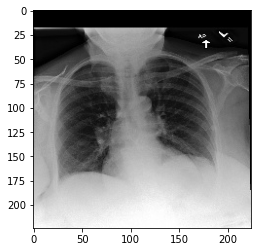

In [40]:
import matplotlib.image as mpimg

plt.imshow(mpimg.imread(combined_dataset.val.iloc[0].img), cmap="gray")

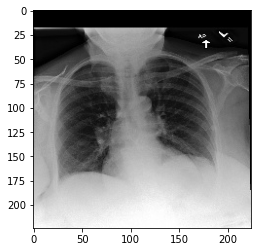

In [41]:
plt.imshow(val_generator.__getitem__(0)[0][0][:,:,0], cmap="gray")

In [42]:
results = model.evaluate(val_generator)
print("test loss, test acc:", results)

144/144 [==============================] - 14s 96ms/step - loss: 0.5552 - accuracy: 0.7394
test loss, test acc: [0.5552111268043518, 0.7393582463264465]


In [43]:
print("Test pneumonia cases: ", len(combined_dataset.val[combined_dataset.val['label_pneumonia'] == 1]))
print("Test normal cases: ", len(combined_dataset.val[combined_dataset.val['label_pneumonia'] == 0]))

Test pneumonia cases:  2291
Test normal cases:  2290


In [44]:
predictions = model.predict(val_generator)

In [45]:
val_generator

In [46]:
y_true = combined_dataset.val.label_pneumonia # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [47]:
y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("NORMAL")
    else:
        y_pred_classes.append("PNEUMONIA")

In [48]:
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("NORMAL")
    else:
        y_true_classes.append("PNEUMONIA")

In [49]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[1804  486]
 [ 708 1583]]


In [50]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.72      0.79      0.75      2290
   PNEUMONIA       0.77      0.69      0.73      2291

    accuracy                           0.74      4581
   macro avg       0.74      0.74      0.74      4581
weighted avg       0.74      0.74      0.74      4581



[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

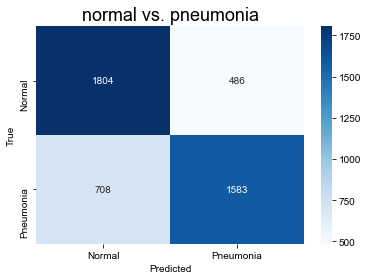

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues') #annot=True to annotate cells
sns.set(font_scale=1.5)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('normal vs. pneumonia')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])

## Validation on an exernal dataset

In [52]:
#external_testset = original_dataset('cxr14', 'ChestX-ray14_NationalInstituesofHealthClinicalCenter_224/')
#external_testset = original_dataset('chexpert', 'CheXpert_224/')
external_testset = original_dataset('padchest', 'BIMCV-PadChest_224/')
#external_testset = original_dataset('kermany', 'KermanyChildStudy_224/')
external_testset.shuffle()
external_testset.stratified_train_test_val_split(stratify_column='label_pneumonia')

Successfully created padchest dataset
Splitting in: 0.7 train, 0.2 test, 0.1 val


In [53]:
print('Zusammenfassung der externen Validierungsdaten:')
n_normal = sum(external_testset.df.label_pneumonia < 0.5)
n_pneumonia = sum(external_testset.df.label_pneumonia > 0.5)
print('Anzahl Samples:', len(external_testset.df), '   ->', n_normal,'normal,', n_pneumonia, 'pneumonia')
print('         Train:', len(external_testset.train),'   ->', sum(external_testset.train.label_pneumonia < 0.5), 'normal,', sum(external_testset.train.label_pneumonia > 0.5), 'pneumonia')
print('          Test:', len(external_testset.test),'   ->', sum(external_testset.test.label_pneumonia < 0.5), 'normal,', sum(external_testset.test.label_pneumonia > 0.5), 'pneumonia')
print('           Val:', len(external_testset.val),'   ->', sum(external_testset.val.label_pneumonia < 0.5), 'normal,', sum(external_testset.val.label_pneumonia > 0.5), 'pneumonia')

Zusammenfassung der externen Validierungsdaten:
Anzahl Samples: 10441    -> 5221 normal, 5220 pneumonia
         Train: 7308    -> 3654 normal, 3654 pneumonia
          Test: 2088    -> 1044 normal, 1044 pneumonia
           Val: 1045    -> 523 normal, 522 pneumonia


In [54]:
ext_generator = data_generator.flow_from_dataframe(
        dataframe=external_testset.test,
        **flow_arguments
    )

#external_testset.test.reset_index(drop=True, inplace=True)
#external_datagenerator = DataGenerator(external_testset.test, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

Found 2088 non-validated image filenames.


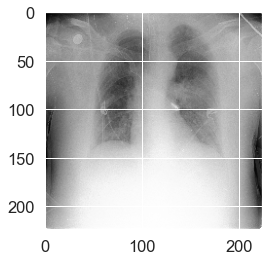

In [55]:
import matplotlib.image as mpimg

plt.imshow(mpimg.imread(external_testset.test.iloc[1].img), cmap="gray")

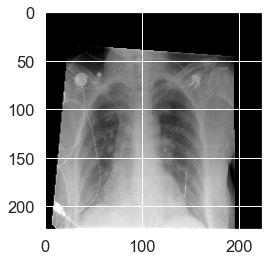

In [56]:
plt.imshow(ext_generator.__getitem__(1)[0][0][:,:,0], cmap="gray")

In [57]:
external_pred = model.predict(ext_generator)

In [58]:
y_true = external_testset.test.label_pneumonia # we can do this since we do not shuffle in test_generator ;)
y_pred = external_pred > 0.5

y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("NORMAL")
    else:
        y_pred_classes.append("PNEUMONIA")
        
        
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("NORMAL")
    else:
        y_true_classes.append("PNEUMONIA")

In [59]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.69      0.73      0.71      1044
   PNEUMONIA       0.71      0.67      0.69      1044

    accuracy                           0.70      2088
   macro avg       0.70      0.70      0.70      2088
weighted avg       0.70      0.70      0.70      2088



In [60]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[763 281]
 [340 704]]
